<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/Fourier/Fourier_series_%2B_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)

In [ ]:
# Convert the date column to a datetime object
df['DT'] = pd.to_datetime(df['DT'], format='%Y-%m-%d')

# Set the date column as the index of the dataframe
df.set_index('DT', inplace=True)
df['ANTAL_01'] = df['ANTAL_01'].astype(int)
df = df.iloc[::-1]

In [ ]:
#training and test
training = df.iloc[:-16,:]
print(training.index)
testing = df.iloc[-16:, :]
training.head()

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23', '2022-11-24', '2022-11-25',
               '2022-11-28', '2022-11-29'],
              dtype='datetime64[ns]', name='DT', length=1802, freq=None)


,ANTAL_01
DT,
2015-12-31,46084
2016-01-04,46026
2016-01-05,46108
2016-01-06,45995
2016-01-07,45954


In [ ]:
# Define number of Fourier terms to use
n_terms = 3

# Define the time period of the data (in this example, one year)
period = 365

In [ ]:
# Create Fourier series terms
t = np.arange(len(training))
fourier_terms = []
for i in range(1, n_terms+1):
    fourier_terms += [np.sin(2*np.pi*i*t/period), np.cos(2*np.pi*i*t/period)]

In [ ]:
# Add Fourier series terms to data frame
fourier_df = pd.DataFrame(np.array(fourier_terms).T, index=training.index, columns=[f'fourier_{i+1}' for i in range(2*n_terms)])
training = pd.concat([training, fourier_df], axis=1)

In [ ]:
len(training)

1802

In [ ]:
# Specify exogenous variables for SARIMAX model
exog_vars = ['fourier_{}'.format(i+1) for i in range(n_terms)]

In [ ]:
# Train SARIMAX model with exogenous variables
model = sm.tsa.statespace.SARIMAX(training['ANTAL_01'], exog=training[exog_vars], order=(1,1,1), seasonal_order=(1,0,1,22))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
exogTest = training.tail(22)
exogTest2 = exogTest.head(len(testing))
exogTest2
exogvar = np.asarray(exogTest2[exog_vars])
exogvar = np.asarray(exogTest2[exog_vars])
exogvar
test_exog = pd.DataFrame(exogvar, index=testing.index)
test_exog

,0,1,2
DT,,,
2022-11-30,-0.699458,0.714673,-0.999769
2022-12-01,-0.687053,0.726608,-0.998435
2022-12-02,-0.674444,0.738326,-0.995919
2022-12-05,-0.661635,0.749826,-0.992222
2022-12-06,-0.648630,0.761104,-0.987349
2022-12-07,-0.635432,0.772157,-0.981306
2022-12-08,-0.622047,0.782980,-0.974100
2022-12-09,-0.608477,0.793572,-0.965740
2022-12-12,-0.594727,0.803928,-0.956235


In [ ]:
# predict using SARIMAX model
pred = results.predict(start=len(training), end=len(training)+len(testing)-1, exog=test_exog)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
pred, testing['ANTAL_01']

(1802    31729.950125
 1803    31939.936730
 1804    31879.116795
 1805    31652.682349
 1806    31510.096204
 1807    31474.803032
 1808    31474.623943
 1809    31436.198830
 1810    31425.517370
 1811    31407.486919
 1812    31346.408986
 1813    31347.919562
 1814    31305.558541
 1815    31281.241978
 1816    31262.353991
 1817    31223.724148
 Name: predicted_mean, dtype: float64,
 DT
 2022-11-30    32207
 2022-12-01    32524
 2022-12-02    32418
 2022-12-05    30902
 2022-12-06    30743
 2022-12-07    30590
 2022-12-08    30455
 2022-12-09    30444
 2022-12-12    30339
 2022-12-13    30277
 2022-12-14    30179
 2022-12-15    30280
 2022-12-16    30213
 2022-12-19    30152
 2022-12-20    30121
 2022-12-21    30090
 Name: ANTAL_01, dtype: int64)

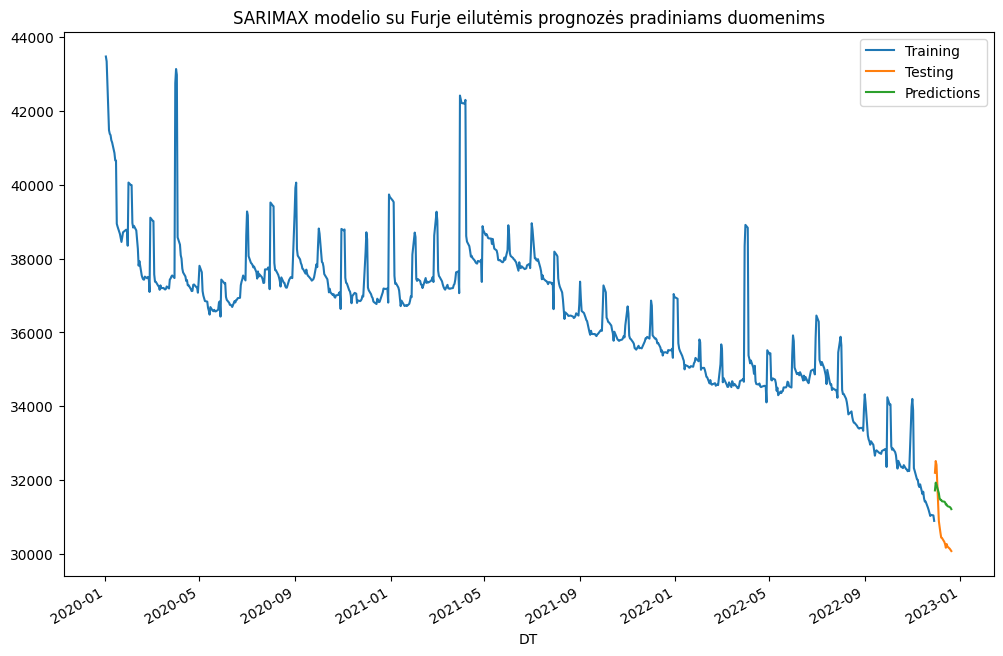

In [ ]:
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
testing['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = testing.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su Furje eilutėmis prognozės pradiniams duomenims')
plt.legend()